In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

# df = pd.read_csv("train_clean.csv").drop(columns="Unnamed: 0")
# y = df.severity
# X = df.drop(columns='severity')
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# print(f"Train size: {len(y_train)} - Test size: {len(y_test)}")

In [3]:
TO_DROP = [
    'civil_twilight',    'nautical_twilight',
    'astronomical_twilight',    'desc_0', 
    'desc_1',     'desc_2', 
    'desc_3',     'desc_4', 
    'desc_5',     'desc_6', 
    'desc_7',     'desc_8', 
    'desc_9',     'desc_10',
    'desc_11',    'desc_12',    'desc_13',
    'desc_14',    'desc_15',
    'desc_16',    'desc_17',
    'desc_19',    'end_lat', 
    'end_lng',    'end_month',
    'end_day',
]

df_train = pd.read_csv("train_clean_prep.csv").drop(columns="Unnamed: 0")
df_test = pd.read_csv("test_clean_prep.csv").drop(columns="Unnamed: 0")

df_train = df_train.drop(columns=TO_DROP)
df_test = df_test.drop(columns=TO_DROP)

X_train, y_train = df_train.drop(columns='severity'), df_train.severity
X_test, y_test = df_test.drop(columns='severity'), df_test.severity

In [4]:
df = pd.read_csv("train_pca.csv").drop(columns="Unnamed: 0")

In [5]:
X, y = df.drop(columns='severity'), df.severity

## Model Selection

Models to test:
- KNN
- SVC (RBF)
- Random Forest
- Naive bayes
- XGBClassifier

In [6]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### First runs

In [11]:
knn = KNeighborsClassifier(10)

In [12]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [13]:
y_pred = knn.predict(X_test)
y_scores = knn.predict_proba(X_test)

In [14]:
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

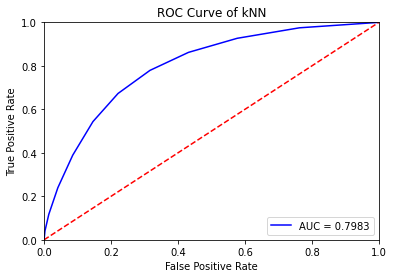

In [15]:
# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      7025
           1       0.70      0.54      0.61      4434

    accuracy                           0.73     11459
   macro avg       0.72      0.70      0.70     11459
weighted avg       0.73      0.73      0.73     11459



In [18]:
# xgb_bm = XGBClassifier(n_estimators=200, n_jobs=-1)
# xgb_bm = XGBClassifier(n_estimators=400, n_jobs=-1)
xgb_bm = XGBClassifier(n_estimators=600, n_jobs=-1)
xgb_bm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
xgb_pred = xgb_bm.predict(X_test)
xgb_scores = xgb_bm.predict_proba(X_test)

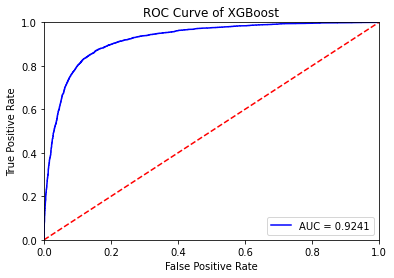

In [20]:
fpr, tpr, threshold = roc_curve(y_test, xgb_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.show()

In [21]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      7025
           1       0.83      0.81      0.82      4434

    accuracy                           0.86     11459
   macro avg       0.86      0.85      0.85     11459
weighted avg       0.86      0.86      0.86     11459



xgb_bm.save_model(f"xgboost_model_{hash(xgb_bm)}_9257")

In [ ]:
### Cross-validation & Grid Search

knn_cv = KNeighborsClassifier()

param_grid = {'n_neighbors': range(5, 22, 2)}

knn_gscv = GridSearchCV(knn_cv, param_grid, cv=15, verbose=2)

#fit model to data
knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
knn_gscv.best_params_

knn_gscv.best_score_

bknn = knn_gscv.best_estimator_

y_pred_cv = bknn.predict(X_test)
y_score_cv = bknn.predict_proba(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_score_cv[:, 1])
roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

print(classification_report(y_test, y_pred_cv))

### Other Models

classifiers = {
    "knn": KNeighborsClassifier(),
    "svc": SVC(),
    "r_forest": RandomForestClassifier(),
    "naive_bayes": GaussianNB(),
    "xgbc": XGBClassifier,
}

grids = {
    "knn": {
        "n_neighbors": range(4,21,2),
    },
    "svc": {
        "C": [1, 2],
        "kernel": ['rbf', 'sigmoid'],
        "class_weight": [None, "balanced"],
    },
    "r_forest": {
        "n_estimators": [100, 200, 400, 600, 1000, 1400, 1800, 2400],
        "n_jobs": [-1]
    },
    "xgbc": {
        "n_estimators": [100, 400, 600, 1400],
    }
}

svc = GridSearchCV(classifiers['svc'], grids['svc'], cv=15, verbose=2)

xgb = classifiers["xgbc"](n_jobs=-1)

xgb

xgb_cv = GridSearchCV(xgb, grids["xgbc"], cv=15, verbose=2)

xgb_cv.fit(X_train, y_train)

#check top performing n_neighbors value
xgb_cv.best_params_

xgb_cv.best_score_

xgb_bm = xgb_cv.best_estimator_